In [1]:
import matplotlib
import numpy as np
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Epsiode")
    plt.ylabel("Epsiode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Epsiode")
    plt.ylabel("Epsiode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

In [3]:
import numpy as np

from collections import defaultdict
#from lib import plotting

deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

class BlackJack(object):
    """Create an environment of a Black Jack Game
    dealer = list - dealer list card in his deck
    player = list - player list card in his deck
    done = bool - True if the game is done, and False otherwise
    this class only can be accessed from act(), reset(), state()
    act() = PARAMS : 1 if hit, 0 if stick
            RETURN : (state), done_status, reward
    reset() = PARAMS : None
              RETURN : None
    state() = PARAMS : None
             RETURN : (state)
    (state) is a tuple of player score, dealers score, usable ace condition
    Black Jack Refferences:
    [1] https://webdocs.cs.ualberta.ca/~sutton/book/ebook/node51.html (Example 5.1)
    [2] http://www.bicyclecards.com/how-to-play/blackjack/
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.dealer = [self.draw()]
        self.player = [self.draw()]
        self.done = False

    def natural(self,hand): # check if he got natural/blackjack condition
        return sorted(hand)==[1,10]

    def draw(self): # get one card
        return np.random.choice(deck)

    def usable(self, hand): # check if he got usable ace condition
        return 1 in hand and sum(hand) + 10 <= 21

    def busted(self, hand): # check if he got busted
        return self.sum_hand(hand) > 21

    def sum_hand(self, hand):
        if self.usable(hand):
            return sum(hand) + 10
        else:
            return sum(hand)

    def state(self):
        return self.sum_hand(self.player), self.sum_hand(self.dealer), \
                    self.usable(self.player)

    def act(self, hit):
        if not self.done:
            if hit:
                self.hit()
                if self.busted(self.player):
                    self.done = True
                    return self.state(), self.done, -1
                else:
                    return self.state(), self.done, 0
            else:
                return self.stick()

    def hit(self):
        self.player.append(self.draw())

    def stick(self):
        self.done = True

        # Dealer doing hit while his score below 17
        # see refference [2]
        while self.sum_hand(self.dealer) < 17:
            self.dealer.append(self.draw())

        # player'll never get busted in here so just sum it
        player_score = self.sum_hand(self.player)

        dealer_score = -1 if self.busted(self.dealer) else self.sum_hand(self.dealer)

        if self.natural(self.player) and self.natural(self.dealer):
            reward = 1
#         elif self.natural(self.player):
#             reward = 1.5
        elif dealer_score > player_score:
            reward = -1
        elif dealer_score < player_score:
            reward = 1
        else:
            reward = 0

        return self.state(), self.done, reward

In [4]:
env = BlackJack()

In [5]:
def policy_0(pl_score, de_score, use_ace):
    """Policy-0 : always "hit" except we got score >= 20
    """

    # Using probability instead of actual act number for consistency
    return np.array([1.0, 0.0]) if pl_score >= 20 else np.array([0.0, 1.0])

In [6]:
def policy_epsilon(Q, epsilon, state):
    """Policy-epsilon :
       - always hit when player score < 12
       - otherwise:
       - epsilon probability choosing random action
       - 1-epsilon probability choosing action wich has maximum Q value
    """

    # Greedy choose hit when score < 12
    if state[0] < 12:
        return [0.0, 1.0]

    if np.random.rand() <= epsilon:
        # Explore
        return np.array([0.5, 0.5])
    else:
        # Exploit
        best_action = np.argmax(Q[state])
        A = np.zeros(2)
        A[best_action] = 1
        return A

In [7]:
def td_prediction(policy, n_episodes, alfa=1.0, discount=1.0, env=env):

    # Make a dictionary with deafult value 0.0
    V = defaultdict(float)

    for e in range(n_episodes):
        env.reset()
        now_state = env.state()
        terminate = False

        # Running an episode
        while not terminate:
            # Chosen action
            act_prob = policy(*now_state)
            action = np.random.choice(np.arange(len(act_prob)), p=act_prob)

            # Take action
            next_state, done, reward = env.act(action)

            # Not waiting to generate one episode for TD update
            delta = reward + discount * V[next_state] - V[now_state]
            V[now_state] = V[now_state] + alfa * delta
#             print(f'state: {now_state}, V[state]: {V[now_state]}')

            # Move to the next state
            now_state = next_state

            if done:
                terminate = True

    return V

In [12]:
# td_control a.k.a SARSA
def td_control(policy, n_episodes, alfa=1.0, epsilon=0.1, discount=1.0, env=env):

    # Make a dictionary with deafult value 0.0
    Q = defaultdict(lambda: [0.0, 0.0])

    for e in range(n_episodes):

        env.reset()
        now_state = env.state()
        terminate = False

        # Chosen action
        act_prob = policy(Q, epsilon, now_state)
        action = np.random.choice(np.arange(len(act_prob)), p=act_prob)

        # Generate one episode
        while not terminate:

            # Take action
            next_state, done, reward = env.act(action)

            # Get next action
            next_act_prob = policy(Q, epsilon, next_state)
            next_action = np.random.choice(np.arange(len(next_act_prob)),
                                                           p=next_act_prob)

            # Not waiting to generate one episode for TD update
            delta = reward + discount * Q[next_state][next_action] \
                                                - Q[now_state][action]
            Q[now_state][action] = Q[now_state][action] + alfa * delta
#             print(f'state: {now_state}, action: {action}: Q={Q}')

            # Move to the next state
            now_state = next_state
            action = next_action

            if done:
                terminate = True

    return Q, policy

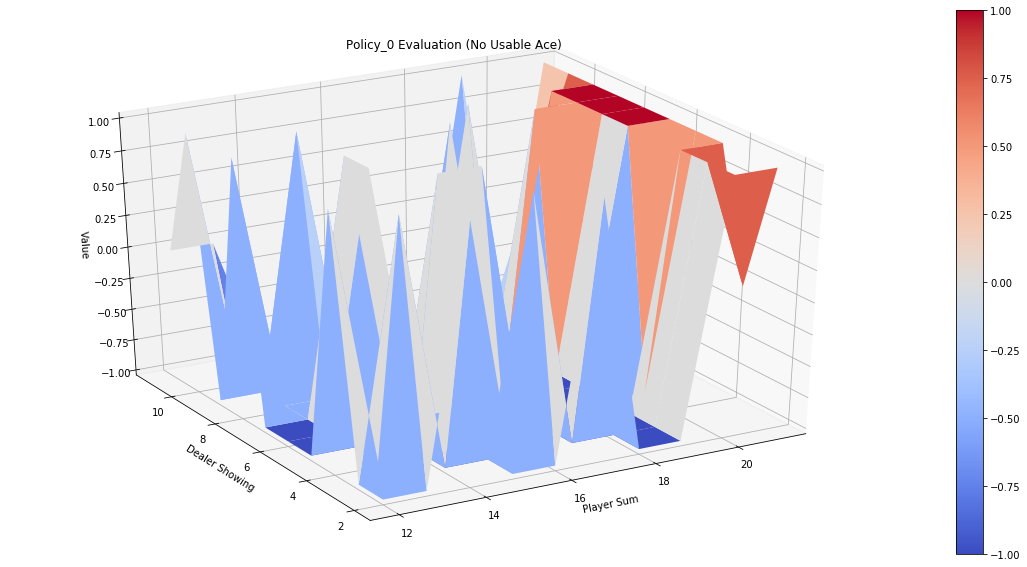

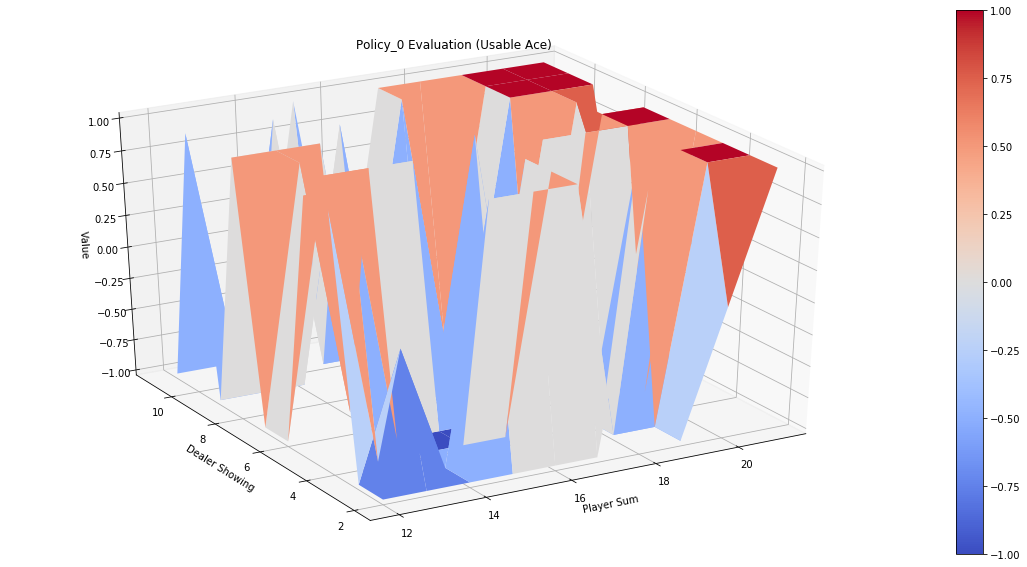

In [9]:
"""Block code below evaluate a policy and return a plotted V-value
"""

V = td_prediction(policy_0, n_episodes=10000)

# Delete state with player score below 12 to make it same with example
# Because we call V[next_state] in the end, to make the same plot
# we should delete some keys
new_V = defaultdict(float)
for key, data in V.items():
    if key[0] >= 12 and key[1]<=11 and key[0]<=21:
        new_V[key] = data

# Using plotting library from Denny Britz repo
plot_value_function(new_V, title="Policy_0 Evaluation")

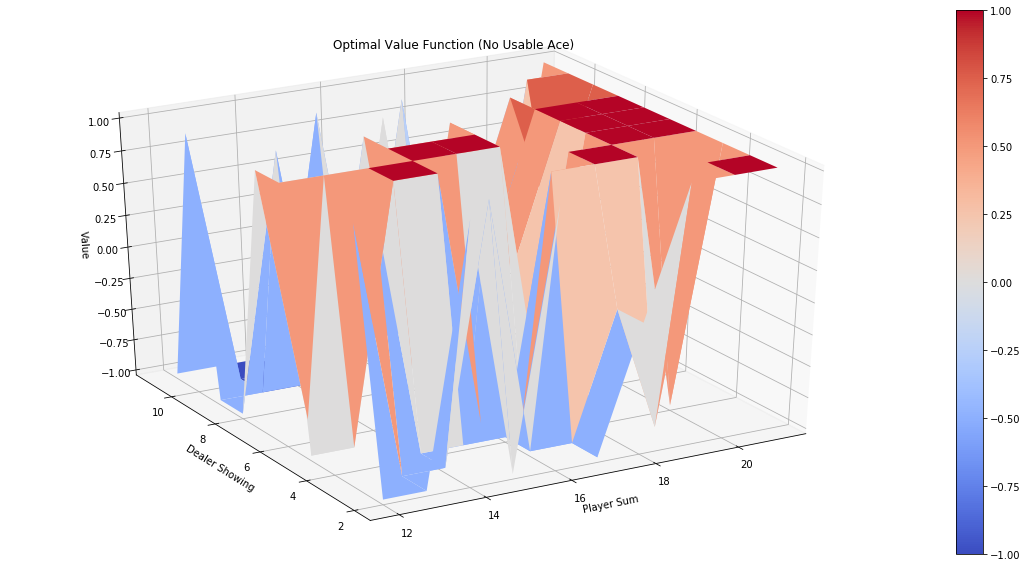

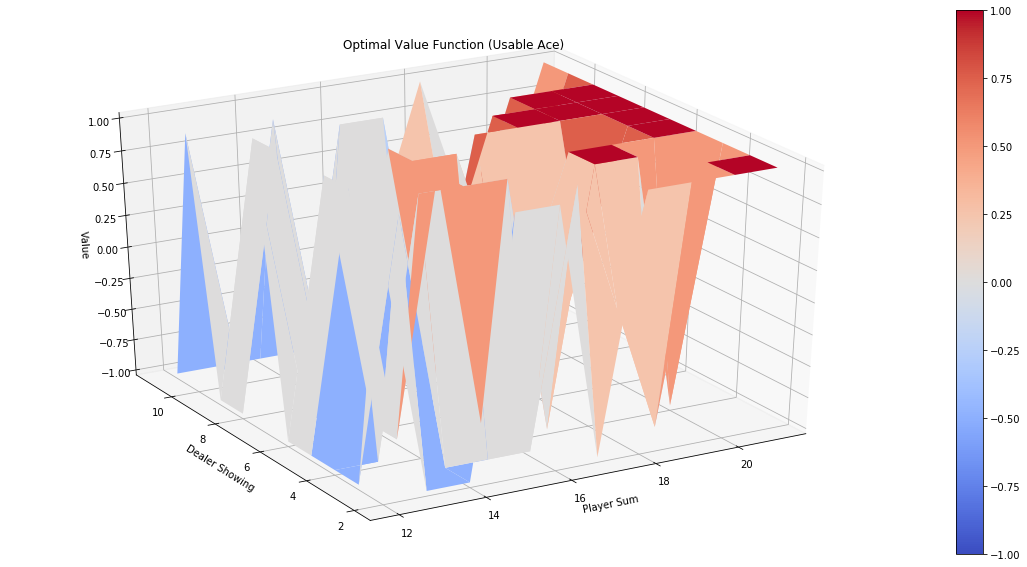

In [13]:
"""Block code below optimize Q by a policy and return Q and plotted V-value
"""
# print("TEMPORAL-DIFFERENCE CONTROL A.K.A SARSA OPTIMIZE THE POLICY AND Q-VALUE")

Q, policy = td_control(policy_epsilon, n_episodes=500000)

# For plotting purpose, find V-value from Q-Value
V = defaultdict(float)
for state, actions in Q.items():
    action_value = max(actions)
    V[state] = action_value

# Delete state with player score below 12 and dealer more than 11
# to make it same with example
new_V = defaultdict(float)
for key, data in V.items():
    if key[0] >= 12 and key[1]<=11 and key[0]<=21:
        new_V[key] = data

# Using plotting library from Denny Britz repo
plot_value_function(new_V, title="Optimal Value Function")


In [16]:
"""Block code below using optimized Q-value and policy before,
Then run it on a game
"""
print("SIMULATE THE OPTIMIZED POLICY AND Q-VALUE")

def print_state( pl_score, de_score, use_ace, reward=0):
    if env.done:
        print ("== Game Over ==")
        print ("Reward: {}".format(reward))
    print ("Player: {} | Dealer: {} | Usable Ace: {}".format(
                pl_score, de_score, use_ace))

    # You shouldn't print deck list
    print ("Player Deck: {}".format(env.player))
    print ("Dealer Deck: {}".format(env.dealer))

def act(hit, env=env):
    state, done, reward = env.act(hit)
    pl_score, de_score, use_ace = state
    print_state(pl_score, de_score, use_ace, reward)
    return state, done, reward

def reset(env=env):
    env.reset()
    pl_score, de_score, use_ace = env.state()
    print_state(pl_score, de_score, use_ace)
    return pl_score, de_score, use_ace

state = reset()
done = False
while not done:
    print ("")
    action = 1 if state[0]<12 else np.argmax(Q[state])
    print ("action: HIT" if action==1 else "action: STICK")
    state, done, reward = act(action)

SIMULATE THE OPTIMIZED POLICY AND Q-VALUE
Player: 11 | Dealer: 10 | Usable Ace: True
Player Deck: [1]
Dealer Deck: [10]

action: HIT
Player: 21 | Dealer: 10 | Usable Ace: True
Player Deck: [1, 10]
Dealer Deck: [10]

action: STICK
== Game Over ==
Reward: 1
Player: 21 | Dealer: 19 | Usable Ace: True
Player Deck: [1, 10]
Dealer Deck: [10, 9]
